# Fit Mock Spectrum using Bayesian Method
In this notebook, we will fit a mock spectrum using the Bayesian method (`emcee`) implemented in `LUCI`. The goal of this notebook is to showcase the Bayesian fits and uncertainty calculations. 

Normally, to fit a spectrum in `LUCI` using `emcee`, you would add the argument `bayes=True` to one of the fitting methods (i.e., `fit_pixel()`). Since we are fitting a mock spectrum and not one pulled from the cube, we will call the fitting function `LuciFit`. This requires us to pass some additional parameters that are normally handled internally in `LUCI`. 

In [1]:
import sys
Luci_path = '/home/crhea/Documents/LUCI/'
sys.path.insert(0, Luci_path)  # Location of Luci
from LUCI.LuciSim import Spectrum
import matplotlib.pyplot as plt
import numpy as np
import LUCI.LuciFit as lfit
from LUCI.LuciUtility import read_in_reference_spectrum


2024-12-05 11:59:18.472089: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 11:59:18.474335: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 11:59:18.508410: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 11:59:18.508442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 11:59:18.509127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

We will now use `Spectrum` to create a mock spectrum. We have to put in the following details.

In [2]:
lines = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']  # Lines to model
fit_function = 'sincgauss'  # Function to model
ampls = [2, 1, 1/3, 0.5, 0.45]  # Just randomly choosing these amplitudes
velocity = 0  # km/s
broadening = 10  # km/s
filter_ = 'SN3'  # Filter to model
resolution = 5000  # Resolution 
snr = 100  # Signal to noise ratio

In [3]:
spectrum_axis, spectrum = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()
spectrum += 1  # Add a continuum

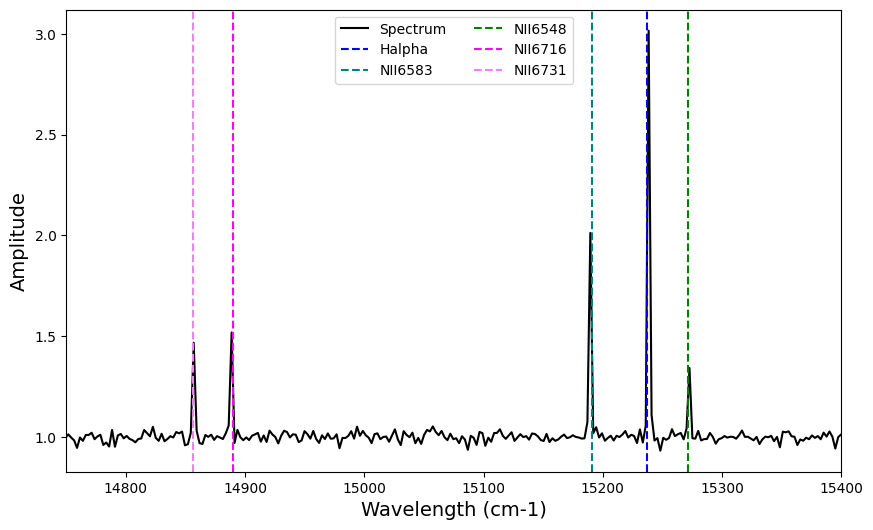

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(spectrum_axis, spectrum, color='black', label='Spectrum')
plt.xlim(14750, 15400)
plt.xlabel('Wavelength (cm-1)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.axvline(1e7 / 656.3, label='Halpha', color='blue', linestyle='--')
plt.axvline(1e7 / 658.3, label='NII6583', color='teal', linestyle='--')
plt.axvline(1e7 / 654.8, label='NII6548', color='green', linestyle='--')
plt.axvline(1e7 / 671.6, label='NII6716', color='magenta', linestyle='--')
plt.axvline(1e7 / 673.1, label='NII6731', color='violet', linestyle='--')
plt.legend(ncol=2)

plt.show()

In [5]:
wavenumbers_syn, _ = read_in_reference_spectrum(ref_spec=Luci_path + 'ML/Reference-Spectrum-R%i-%s.fits' % (resolution, filter_),hdr_dict={"FILTER":filter_})  # Normally done internally by LUCI
fit = lfit.Fit(spectrum=spectrum,
               axis=spectrum_axis, 
               wavenumbers_syn=wavenumbers_syn, 
               model_type='gaussian',
               lines=['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               vel_rel=[1,1,1,1,1], 
               sigma_rel=[1,1,1,1,1],
               filter=filter_,
               resolution=resolution,
               Luci_path=Luci_path,
               bayes_bool=True, bayes_method='emcee',
               uncertainty_bool=False)
fit_dict = fit.fit()  # Run fit

100%|██████████| 2000/2000 [00:07<00:00, 281.22it/s]


<Figure size 640x480 with 0 Axes>

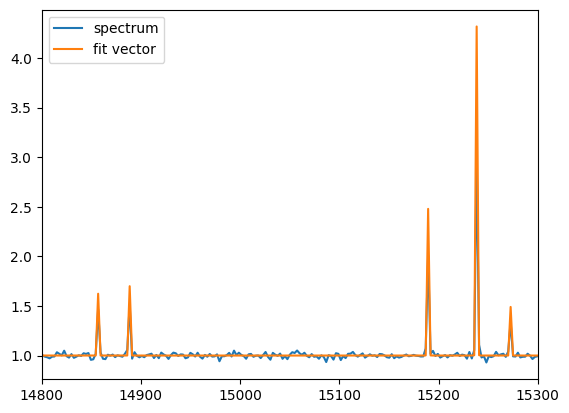

In [6]:
plt.plot(spectrum_axis, spectrum, label='spectrum')
plt.plot(spectrum_axis, fit_dict['fit_vector'], label='fit vector')
plt.xlim(14800, 15300)
plt.legend()

In [7]:
fit_dict.keys()

dict_keys(['fit_sol', 'fit_uncertainties', 'amplitudes', 'fluxes', 'flux_errors', 'chi2', 'velocities', 'sigmas', 'vels_errors', 'sigmas_errors', 'axis_step', 'corr', 'continuum', 'continuum_error', 'scale', 'vel_ml', 'vel_ml_sigma', 'broad_ml', 'broad_ml_sigma', 'fit_vector', 'fit_axis'])

We can calculate the uncertainty lower bound in km/s and compare it to our fit error. Let's do this for H$\alpha$. The wavenumber is 15244.4 cm$^{-1}$. The step resolution (which we can get from `fit_dict['axis_step']` is 2.524 cm$^{-1}$. We can calculate the velocity resolution as:

$$ \Delta v = c \cdot{} \frac{\Delta \nu}{\nu_0}  = 299,792 \text{km/s} * \Bigg(\frac{2.524 \text{cm$^{-1}$}}{15244.4\text{cm$^{-1}$}}\Bigg) \approx 49.6 \text{km/s}$$

In the uncertainties documentation, we demonstrated that $$\delta \mu = \frac{\sqrt{2}\cdot{}\text{FWHM}}{\text{SNR}\cdot{} \sqrt{N}}$$ for a single line. For multiple lines, we have 

$$ \delta \mu_{multi} \approx \delta \mu_{single} \cdot{} \frac{1}{\sqrt{M}} $$

Again, following the calculations from the documentation, we know

$$ \delta \mu = \frac{ \sqrt{2} \cdot{} 49.64 \text{km/s}^{-1} }{ 100 \cdot{} \sqrt{10} } \approx 0.222 \text{km/s} $$

So 

$$ \delta \mu_{multi} \approx  0.1 \text{km/s} $$

since we are fitting 5 lines simultaneously. 

Let's extract the velocity error from our fit and compare it with the theoretical value.



In [8]:
Halpha_vel_error = fit_dict['vels_errors'][0]
print(f"The Halpha velocity error is {np.round(Halpha_vel_error,2)} km/s.")

The Halpha velocity error is 19.9 km/s.


Well they are pretty darn close! 

Now, this works for a Gaussian fit. For a sincgauss fit, the calculation becomes more complex because we have to use an effective SNR and the FWHM of the sincgauss function. For high resolution, the contribution of the sinc lobes is minimized, so the Gaussian dominates. Practically, this means that the estimate we have for the Gaussian is OK for the sincgauss in high resolution observations. 

Let's see what we get for a sincgauss fit.


In [ ]:
fit = lfit.Fit(spectrum=spectrum,
               axis=spectrum_axis, 
               wavenumbers_syn=wavenumbers_syn, 
               model_type='sincgauss',
               lines=['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               vel_rel=[1,1,1,1,1], 
               sigma_rel=[1,1,1,1,1],
               filter=filter_,
               resolution=resolution,
               Luci_path=Luci_path,
               bayes_bool=False, bayes_method='emcee',
               uncertainty_bool=True)
fit_dict = fit.fit()  # Run fit

plt.plot(spectrum_axis, spectrum, label='spectrum')
plt.plot(spectrum_axis, fit_dict['fit_vector'], label='fit vector')
plt.xlim(14800, 15300)
plt.legend()

Halpha_vel_error = fit_dict['vels_errors'][0]
print(f"The Halpha velocity error is {np.round(Halpha_vel_error,2)} km/s.")

In this case, the velocity error is slightly smaller. This is reasonable because the sincgauss is a better model for the underlying spectrum! This can also be the case since the effective FWHM can be more narrow (i.e. a smaller value) when taking into account the sinc function.


I hope this has been instructive!